In [1]:
import sys
sys.path.insert(0, "../..")
def set_size(width = "thesis", fraction=1, subplots=(1, 1)):
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from os import listdir
from os.path import isfile, join

from module.base.network import Network
from module.simulation.meanfield import MeanField
import module.components.CONST as CONST
from module.simulation.set_meanfield2 import SetMeanField2
from module.simulation.masterequation import MasterEquation
from module.simulation.quick_meanfield2 import QuickMeanField2
from module.simulation.meanfield2 import MeanField2
from module.components.lawrence_dist import LawrenceDist
from module.components.discrete_gaussian1D import DiscreteGaussian1D

from module.components.restricted_gaussian1D import RestrictedGaussian1D
from module.components.p2_4dist import p2_4dist

/tmp/ipykernel_3107/2397363.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def calc_rel_freq(data):
    data = data.round()
    phase_space = np.arange(data.min(), data.max() + 1)
    n = []
    N = data.shape[0]
    for i, val in enumerate(phase_space):
        n.append(np.where(data == phase_space[i])[0].shape[0])

    n = np.array(n)
    probs = n/N

    return phase_space, probs

In [3]:
ld = LawrenceDist()
p2dist = p2_4dist()

In [60]:
island = 6

In [4]:
# i = 15 # voltage config
# island =  9 # island

i = 189 # voltage config
island =  9 # island
voltage_config = np.loadtxt("../../data/cont_comparison/voltage_configs.csv")[i]
kmc_states = np.loadtxt("../../data/cont_comparison/kmc/"+str(i)+"_.csv")
kmc_phase_space, probs_kmc = calc_rel_freq(kmc_states[:, island])
net = Network(4,4,1,[[0,0,0],[3,0,0],[0,3,0],[3,3,0]])
net.set_voltage_config(voltage_config[0:4], 0)

mf = MeanField(net)
mf2 = MeanField2(net, include_covs = True)
mf2_no_cov = MeanField2(net, include_covs = False)
qmf2 = QuickMeanField2(net)

In [10]:
means = np.zeros(16)
qmf2.numeric_integration_solve(N = 0)
qmf2.ADAM_solve(N = 0)

In [28]:
mf2.ADAM_solve(N = 0)

In [18]:
# first order
means = mf.numeric_integration_solve(means, verbose = True)
probs_mf = ld.calc_prob(means[island])

convergence: 6.514405252421773e-05


In [61]:
probs_mf = ld.calc_prob(means[island])

In [83]:
# full second order

mf2.ADAM_solve(verbose = True, N = 30, dt = 0.1, reset = False)
probs_mf2 = mf2.g1.calc_prob(mf2.means[island], mf2.vars[island])

Adam convergence: (0.0933941476935019, 0.06617282502914641, 0.0314239928903061)


In [62]:
probs_mf2 = mf2.g1.calc_prob(mf2.means[island], mf2.vars[island])

In [21]:
# second order cov = 0

mf2_no_cov.ADAM_solve(verbose = True, N = 80)
probs_mf2_no_cov = mf2.g1.calc_prob(mf2_no_cov.means[island], mf2_no_cov.vars[island])

Adam convergence: (0.057207429912004934, 0.05575569538898145, 0.0)


In [63]:
probs_mf2_no_cov = mf2.g1.calc_prob(mf2_no_cov.means[island], mf2_no_cov.vars[island])

In [13]:
# p^2-fdist

#qmf2.numeric_integration_solve(verbose = True, dt = 0.1, reset = False)
qmf2.ADAM_solve(N = 300, verbose = True, reset = False, learning_rate = 0.1)
probs_qmf2 = p2dist.calc_prob(qmf2.means[island], qmf2.vars[island])

ADAM convergence: (0.0025505348195423074, 0.007886550853482834)


In [64]:
probs_qmf2 = p2dist.calc_prob(qmf2.means[island], qmf2.vars[island])

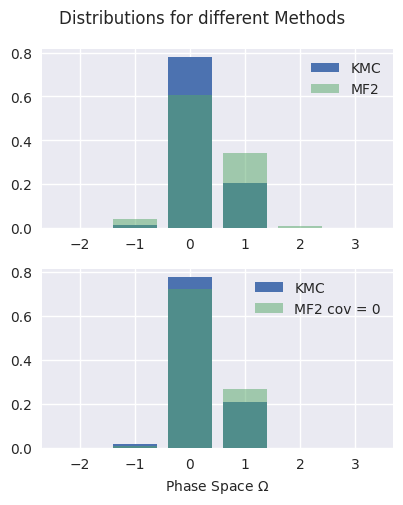

In [84]:
f, axs = plt.subplots(2, 1, figsize = set_size(subplots=(2,1), fraction=0.7))

window = np.arange(20 - 2, 20 + 4)
window2 = np.arange(15 - 2, 15 + 4)

# axs[0].bar(kmc_phase_space, probs_kmc, label = "KMC")
# axs[0].bar(ld.phase_space[window], probs_mf[window], label = "MF1", alpha = 0.5)

# axs[1].bar(kmc_phase_space, probs_kmc, label = "KMC")
# axs[1].bar(p2dist.phase_space[window], probs_qmf2[window], alpha = 0.5, label = "QMF2")


###

axs[0].bar(kmc_phase_space, probs_kmc, label = "KMC")
axs[0].bar(mf2.g1.phase_space[window2], probs_mf2[window2], label = "MF2", alpha = 0.5)

axs[1].bar(kmc_phase_space, probs_kmc, label = "KMC")
axs[1].bar(mf2_no_cov.g1.phase_space[window2], probs_mf2_no_cov[window2], label = "MF2 cov = 0", alpha = 0.5)


axs[0].legend()
axs[1].legend()

axs[1].set_xlabel("Phase Space $\\Omega$")
f.suptitle("Distributions for different Methods")

f.tight_layout()
#plt.savefig("../../output/dist_comparison/dist_comparison1_0.pdf")

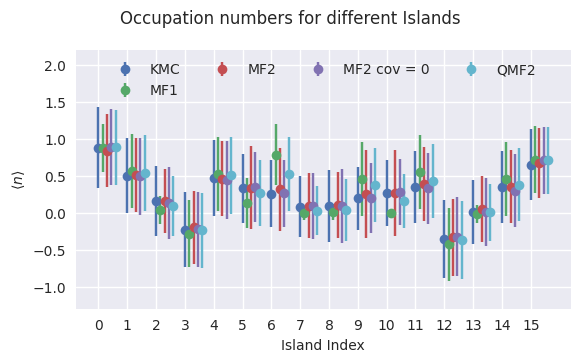

In [85]:
f = plt.figure(figsize = set_size())

plt.errorbar(np.arange(16), np.mean(kmc_states, axis = 0), yerr = np.std(kmc_states, axis = 0), marker = "o", label = "KMC",  linestyle = "")

d =  means - np.floor(means)
plt.errorbar(np.arange(16) + 0.15, means, yerr = np.sqrt(d * (1-d)), linestyle = "", marker = "o", label = "MF1")

plt.errorbar(np.arange(16) + 0.3, mf2.means, yerr = np.sqrt(mf2.vars), linestyle = "", marker = "o", label = "MF2")

plt.errorbar(np.arange(16) + 0.45, mf2_no_cov.means, yerr = np.sqrt(mf2_no_cov.vars), linestyle = "", marker = "o", label = "MF2 cov = 0")

plt.errorbar(np.arange(16) + 0.6, qmf2.means, yerr = np.sqrt(qmf2.vars), linestyle = "", marker = "o", label = "QMF2", color = "C5")

plt.legend(ncol = 4, loc = "upper center")
plt.ylim(-1.3, 2.2)

f.suptitle("Occupation numbers for different Islands")



plt.xticks(np.arange(16), np.arange(16))
plt.xlabel("Island Index")
plt.ylabel("$\\langle n \\rangle$")


f.tight_layout()

#plt.savefig("../../output/dist_comparison/occ_numbers1.pdf")

([<matplotlib.axis.XTick at 0x7f6e3059ed30>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '0'),
  Text(5, 0, '1'),
  Text(6, 0, '2'),
  Text(7, 0, '3'),
  Text(8, 0, '0'),
  Text(9, 0, '1'),
  Text(10, 0, '2'),
  Text(11, 0, '3'),
  Text(12, 0, '0'),
  Text(13, 0, '1'),
  Text(14, 0, '2'),
  Text(15, 0, '3'),
  Text(16, 0, '0'),
  Text(17, 0, '1'),
  Text(18, 0, '2'),
  Text(19, 0, '3')])

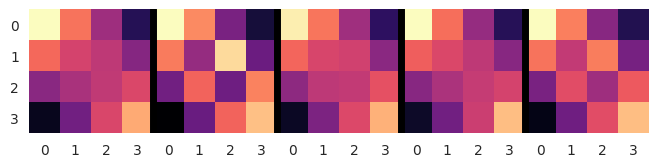

In [115]:
plt.imshow(np.concatenate((np.mean(kmc_states, axis = 0).reshape(4,4), means.reshape(4,4), mf2.means.reshape(4,4), mf2_no_cov.means.reshape(4,4), qmf2.means.reshape(4,4)), axis = 1), cmap = "magma")
plt.grid()
plt.axvline(3.5, color ="black", linewidth = 5)
plt.axvline(7.5, color ="black", linewidth = 5)
plt.axvline(11.5, color ="black", linewidth = 5)
plt.axvline(15.5, color ="black", linewidth = 5)

plt.xticks(np.arange(5*4),[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])